In [52]:
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import seaborn as sns
import pickle
import time
import matplotlib
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import scipy.sparse as sps

# 1. Build the **semantic** network

## Let's prepare a class to clean text, based on **SpaCy**, and to build probability matrices

In [53]:
import spacy
!pip install --quiet spacymoji
from spacymoji import Emoji
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer.token_match = re.compile("^#\w+$").match
nlp.add_pipe("emoji", first=True)

import emoji
def get_emoji_regexp():
    # Sort emoji by length to make sure multi-character emojis are
    # matched first
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = '(' + '|'.join(re.escape(u) for u in emojis) + ')'
    return re.compile(pattern)

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-4268926626.py:5: SyntaxWarning: invalid escape sequence '\w'
  nlp.tokenizer.token_match = re.compile("^#\w+$").match


In [54]:
class SemanticNetwork:
    def __init__(self,nlp):
        self.nlp=nlp

    def _clean_text_fun(self, text, to_keep=True,
               kr_list = ["ADJ","ADV","EMOJI","HASH","NOUN","PROPN","VERB"]):

        # apply spacy
        doc = self.nlp(" ".join(get_emoji_regexp().split(text)))
        # collect spacy outomes in in a list
        out = list()
        for token in doc:
            out.append((token.text, token.text+token.whitespace_,
                        token.lemma_.lower(), token.pos_,
                        token.text.startswith("#"),
                        token.text.startswith("@"),
                        emoji.purely_emoji(token.text),
                        (token.text.startswith("https:") or token.text.startswith("http:"))
                        ))
        # turn it into a dataframe
        df2 = pd.DataFrame(out)
        df2.columns = ['text', 'full_text', 'lemma', 'PoS',
                      'is_hashtag', 'is_mention', 'is_emoji', 'is_link']
        # build a PoS column that identifies hashtags, mentions, etc
        df2.insert(loc = 4, column = 'myPoS', value = df2['PoS'])
        df2.loc[df2['is_hashtag']==True,'myPoS'] = 'HASH'
        df2.loc[df2['is_mention']==True,'myPoS'] = 'MENT'
        df2.loc[df2['is_emoji']==True,'myPoS'] = 'EMOJI'
        df2.loc[df2['is_link']==True,'myPoS'] = 'HTML'
        # replace emojis lemmas with their description
        for tmp in doc._.emoji:
          df2.loc[tmp[1],'lemma'] = tmp[0]+" "+tmp[2]
        # keep/remove only what is asked
        if to_keep:
          out = [j for (i,j) in zip(df2['myPoS'],df2['lemma']) if i in kr_list]
        else:
          out = [j for (i,j) in zip(df2['myPoS'],df2['lemma']) if i not in kr_list]
        return out

    # with to_keep you can choose if you want to keep or remove certain PoS
    #
    # with kr_list you can choose which POS tags to keep or remove,
    # to be chosen from the following list
    #
    # Universal POS Tags http://universaldependencies.org/u/pos/
    #
    #   "ADJ": "adjective",
    #   "ADP": "adposition",
    #   "ADV": "adverb",
    #   "AUX": "auxiliary",
    #   "CONJ": "conjunction",
    #   "CCONJ": "coordinating conjunction",
    #   "DET": "determiner",
    #   "INTJ": "interjection",
    #   "NOUN": "noun",
    #   "NUM": "numeral",
    #   "PART": "particle",
    #   "PRON": "pronoun",
    #   "PROPN": "proper noun",
    #   "PUNCT": "punctuation",
    #   "SCONJ": "subordinating conjunction",
    #   "SYM": "symbol",
    #   "VERB": "verb",
    #   "X": "other",
    #   "EOL": "end of line",
    #   "SPACE": "space"
    #
    # Internal tags
    #
    #   "EMOJI" emojis,
    #   "HASH" hastags
    #   "HTML" web links,
    #   "MENT" mentions

    def clean_text(self, df, to_keep=True,
               kr_list = ["ADJ","ADV","EMOJI","HASH","NOUN","PROPN","VERB"]):

        self.df = df.copy()
        for i in tqdm(range(len(df))):
          text = df.loc[i,'translated']
          self.df.loc[[i],'clean list'] = pd.Series([
                                    self._clean_text_fun(text, to_keep, kr_list)
                                    ], index=[i])

    # extracts occurrence matrix Nwd, also returns the
    # documents actually in use and the words dictionary
    #
    # words occurring less than n_min times are discarded
    # words occurring more than n_max times are discarded
    #
    # documents with zero active words are discarded

    def get_Nwd(self, n_min=2, n_max=1e10):

        # capture execution time
        tic = time.time()

        # collection of (unique) words
        clean_texts_list = list(self.df['clean list'])
        words = np.unique([item for sublist in clean_texts_list \
                                for item in sublist])
        Nw = len(words) # number of words (so far)
        # documents list
        Nd = len(clean_texts_list) # number of documents (so far)
        documents = np.array(range(Nd))

        # occurrence matrix for words in documents
        words_dict = dict(zip(words,range(Nw))) # words dictionary
        Nwd = csr_matrix((Nw, Nd), dtype = np.int8).toarray()
        for i in range(Nd):
            for j in clean_texts_list[i]:
                Nwd[words_dict[j],i] += 1

        # identify words used less than n_min or more than n_max
        select = ((np.sum(Nwd,axis=1) >= n_min) & \
                  (np.sum(Nwd,axis=1) < n_max))
        # explicitly print the most frequent ones
        print('removing words...')
        with np.printoptions(threshold=np.inf):
          print(words[(np.sum(Nwd,axis=1)>=n_max)])
        # remove them
        Nwd = Nwd[select,:]
        words = words[select]
        # remove documents that do not contain words
        select = (np.sum(Nwd,axis=0)>0)
        Nwd = csr_matrix(Nwd[:,select])
        documents = documents[select]

        # capture execution time
        print(f'Occurrence matrix: execution time {time.time()-tic} [s]')

        self.Nwd = Nwd
        self.words = words
        self.documents = documents

        # plot words occurrences
        plt.figure(figsize=(4, 3))
        plt.semilogy(-np.sort(-np.asarray(np.sum(Nwd,axis=1)).reshape(-1)))
        plt.grid(True)
        plt.xlabel('word id')
        plt.ylabel('# of occurrences')
        plt.title("words occurrencies");
        plt.show()

        # build other matrices
        # equally likely documents case!
        Pwd = Nwd/Nwd.sum(axis=0).flatten()/Nwd.shape[1]
        # words and document matrices
        pd = Pwd.sum(axis=0).flatten()
        Pww = (Pwd/pd).dot(Pwd.T)
        pw = Pwd.sum(axis=1).flatten()
        Pdd = (Pwd.T/pw).dot(Pwd)
        self.Pwd = Pwd
        self.Pdd = Pdd
        self.pd = pd

## Import data and build the **semantic network**

In [58]:
# load data
df = pd.read_excel("/content/tweets_greta_translated.xlsx")
df.drop_duplicates(subset=["text"],inplace=True)
df.reset_index(drop=True, inplace=True)

# instantiate the class
sn = SemanticNetwork(nlp)

# run text cleaning ... it takes around 2 mins
sn.clean_text(df[["translated"]], to_keep=True,
              kr_list=["ADJ","ADV","HASH","NOUN","PROPN","VERB"]) # "PRON",

  0%|          | 0/3647 [00:00<?, ?it/s]

removing words...
['#' '#climate' '#climatechange' '#environment' '#sustainability' 'amp'
 'change' 'climate']
Occurrence matrix: execution time 1.222654104232788 [s]


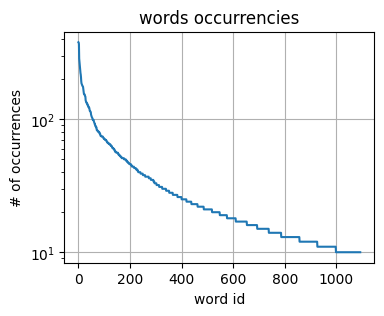

In [63]:
# build Nwd matrix and other probability matrices
sn.get_Nwd(n_min = 10, n_max = 400)

In [64]:
# check how many links in Pdd (very many = slow algorithm)
in_data.Pdd

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3006281 stored elements and shape (3635, 3635)>

In [65]:
# save the result
with open("/content/semantic_net.pkl", 'wb') as f:
    pickle.dump(sn, f)

# 2. Use the **semantic** network

## Run **Louvain**

In [66]:
# load stored data
with open("/content/semantic_net.pkl", 'rb') as f:
    in_data = pickle.load(f)

In [67]:
!pip install --quiet igraph
import igraph as ig

In [68]:
!pip install --quiet leidenalg # this is the Louvain version we use!!!!
import leidenalg

In [69]:
# build a graph based on Pdd as adjacency matrix
A = sps.csr_matrix(in_data.Pdd)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

# run Louvain on the graph to get a partition ... approx 1 min
partition = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition,
                                weights='weight')

/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


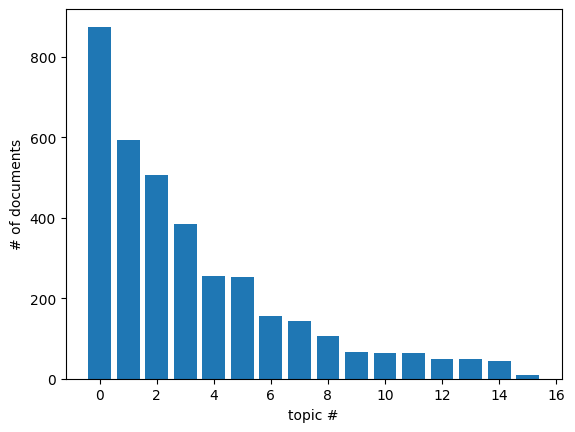

In [70]:
def partition_to_C(partition,Pdd):
      C = sps.csr_matrix((Pdd.shape[0],len(partition)))
      for i in range(len(partition)):
        C[np.array(partition[i]),i] = 1
      return C

# map the partition into a community assignment matrix C
C = partition_to_C(partition,in_data.Pdd)
topics = [np.argmax(i) for i in C] # turn C into a vector!

# builds topic matrices
Pwc = in_data.Pwd.dot(C) # joint word + class probability
Pcc = ((C.T).dot(in_data.Pdd)).dot(C) # joint class + class probability
pc = Pcc.sum(axis=0)

# show number of topics, and size
plt.bar(np.array(range(C.shape[1])),np.array(C.sum(axis=0))[0])
plt.xlabel("topic #")
plt.ylabel("# of documents");

## Prepare functions for **performance** evaluation

In [71]:
def logg(x):
    y = np.log(x)
    y[x==0] = 0
    return y

# NMI
def nmi_fn(A): # A = Pwc
    aw = A.sum(axis=1).flatten() # word probability
    ac = A.sum(axis=0).flatten() # class probability
    Hc = np.multiply(ac,-logg(ac)).sum() # class entropy
    A2 = ((A/ac).T/aw).T
    A2.data = logg(A2.data)
    y = (A.multiply(A2)).sum()/Hc
    return y

# modularity
def modularity_fn(A):
    y = A.trace()-(A.sum(axis=0)*A.sum(axis=1)).item()
    return y

# Ncut
def ncut_fn(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

# Infomap - 1
def pagerank_fn(M,q,c=.85,it=60):
    r = q.copy() # ranking matrix, initialized to q (copy)
    for k in range(it): # slow cycle
      r = c*M.dot(r) + (1-c)*q
    return r

# Infomap - 2
def _infomap_fn(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

# Infomap - 3
def infomap_rank_fn(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = pagerank_fn(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T
    return r

# Infomap - 4
def infomap_fn(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    # extract vectors
    z = (C.T).dot(sps.diags(r.toarray().flatten()))
    q = sps.csr_matrix((1,z.shape[0]))
    c = .85
    for i in range(z.shape[0]):
      tmp = ((C[:,i].transpose()).dot(M)).dot(z[i].transpose())
      q[0,i] = (1-(1-c)*C[:,i].sum()/M.shape[0])*z[i].sum()-c*tmp[0,0]
    # extract statistics
    y = _infomap_fn(q)
    for i in range(z.shape[0]):
      y += _infomap_fn(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    # normalize
    y = (y/_infomap_fn(pd))-1
    return y

## Evaluate **performance**

In [72]:
# extract measures
NMI = nmi_fn(Pwc)
Q = modularity_fn(Pcc)
Ncut = ncut_fn(Pcc)
rd = infomap_rank_fn(in_data.Pdd) # we need the PageRank vector first
Infomap = infomap_fn(C,in_data.Pdd,rd)
if (pc.shape[1]==1):
    com = 0
else:
    com = _infomap_fn(pc)/np.log(pc.shape[1])

/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [73]:
# collect them in dataframe
pd.DataFrame(data = {'topics': C.shape[1], 'com': com,
                     'NMI': NMI, 'Q': Q, 'Ncut': Ncut, 'Infomap': Infomap}, index=[0])

topics       com       NMI         Q      Ncut   Infomap
0      16  0.827923  0.340475  0.216246  0.717445  0.056645

## Let's plot a **word cloud** from Pwc

In [74]:
from wordcloud import WordCloud

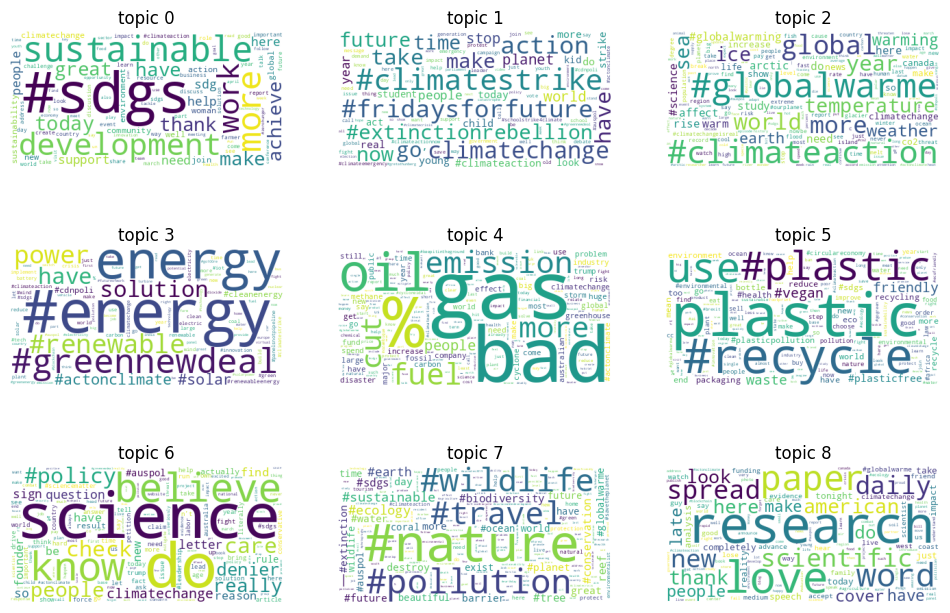

In [75]:
fig, axx = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))

for i in range(9):
  data = Pwc.toarray()[:,i]
  data = [int(i) for i in np.round(1000*data/data.max(),0)]
  data = np.array(data)
  wo = in_data.words[data>0]
  data = data[data>0]

  ax = axx[i//3][i%3]
  wc = WordCloud(background_color='white').generate_from_frequencies(frequencies=dict(zip(wo,data)))
  ax.imshow(wc)
  ax.axis("off")
  ax.set_title("topic "+str(i))

## Show **topic dependencies** by Pcc

In [76]:
!pip install --quiet umap-learn
import umap

CPU times: user 53.9 ms, sys: 7.93 ms, total: 61.8 ms
Wall time: 36.7 ms


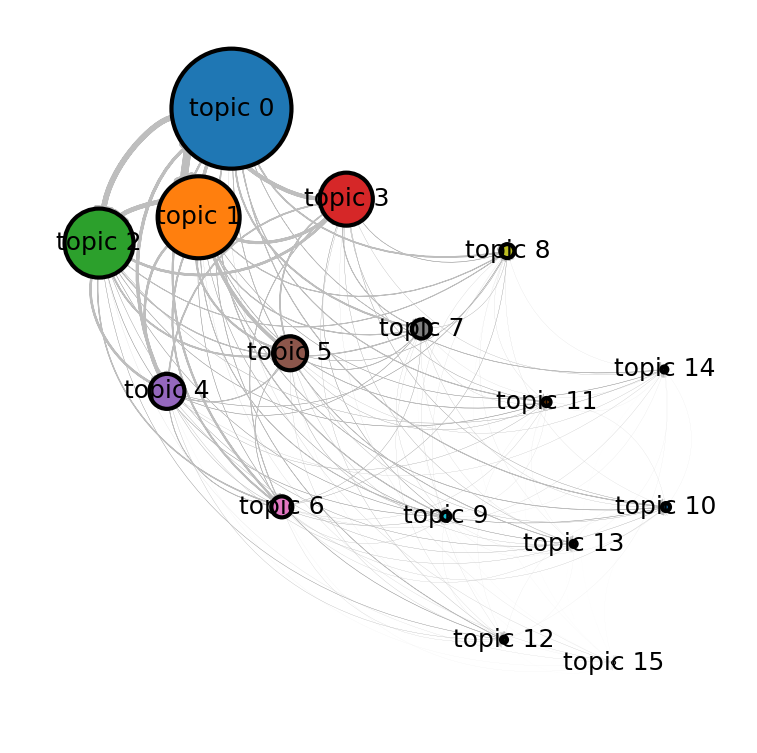

In [77]:
# nodes coordinates by umap: we use communities matrix as adjacency matrix
%time t_pos = umap.UMAP().fit_transform(Pcc.toarray())
t_pos = t_pos-t_pos.mean(0) # we subtract the average values here

# topic centrality by pc
t_cen = np.array(pc)[0]

# topics names
t_names = [f'topic {i}' for i in range(pc.shape[1])]

# topic colors ... hard assignment
t_colors = sns.color_palette("tab10")

# build graph using Pcc
A = Pcc.toarray()
np.fill_diagonal(A, 0)
G = ig.Graph.Adjacency((A>0).tolist())
At = np.tril(A, k=0)
G.es['weight'] = np.array(At[A.nonzero()])

# plot graph
fig, ax = plt.subplots(dpi=300, figsize=(3, 3))
ig.plot(G,
        target = ax,
        layout = t_pos,
        vertex_size = 500*t_cen,
        vertex_color = t_colors,
        vertex_label = t_names,
        vertex_label_size = 6,
        vertex_label_dist = 0,
        edge_width = 60*np.array(G.es["weight"]),
        edge_color = 'gray',
        edge_arrow_size = 0.001
        );